# IMPORTS

In [360]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style; style.use('seaborn-whitegrid')
from matplotlib.ticker import MaxNLocator
from IPython.display import display as disp
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, norm, zscore
import pingouin as pg

In [277]:
jold_types = dict(
    prosp = 8,
    retro = 1,
    short = 2,
    long = 3

)
jold_types_inv = dict((v, k) for k, v in jold_types.items())
measures = [
    'srd',
    'sr',
    'wadSlope',
    'freeChoiceAccepted'
]
cols = ['participant', 'session', 'forced'] + measures
trials = pd.read_csv('../data/clean/trials/summarized_pilot_sessions.csv', index_col=None)
trials = trials.filter(items=cols)
trials = trials.set_index(['participant', 'session']).sort_index()
trials = trials.loc[trials.forced, :].drop(columns=['forced'])
trials = trials.reset_index()

ans_df = pd.read_csv('../data/clean/answers/clean_answers.csv', index_col=None)
all_jolds = ans_df.loc[ans_df.inst.eq('jold')].set_index(['participant', 'session']).sort_index()

## Dataset `q_df`

In [384]:
class paths():
    ans_data = '../data/clean/answers/clean_answers.csv'
    questions_data = '../data/questions/clean_questions.csv'


qs = pd.read_csv(paths.questions_data, index_col=None)
ans = pd.read_csv(paths.ans_data, index_col=None)
ans = pd.merge(ans, qs.filter(items=['inst', 'qid', 'component', 'reverse', 'max_val']), on=['inst', 'qid'])

ccodes = ans.filter(items=['inst', 'component']).drop_duplicates()
ccodes['ccode_num'] = ccodes.groupby('inst').transform(lambda g: [str(i+1) for i in range(len(g))])
ccodes['ccode'] = ccodes['inst'].str.upper()+'_'+ccodes['ccode_num']
ccodes = ccodes.filter(items=['component','ccode'])

print(ans.inst.unique())

# Calculate measures
mask = sum([ans.inst.str.contains(s) for s in ('jold', 'sims', 'tlx', 'mslq')])
ans = ans[mask.astype(bool)]
ans.value.where(~ans.reverse, (ans.max_val+1)-ans.value, inplace=True)
ans = ans.filter(items=['participant', 'session', 'inst', 'component', 'qid', 'value'])
ans = ans.sort_values(by=['participant', 'session', 'inst', 'component', 'qid'])
ans = ans.groupby(['participant', 'session', 'inst', 'component']).mean().reset_index()

# Organize dataframe (each row contains answers to questionnaire items for each participant/session)
ans = ans.merge(ccodes, on='component', how='left')
ans = ans.filter(items=['participant', 'session', 'ccode', 'value'])
ans = ans.pivot(index=['participant','session'], columns='ccode', values='value').reset_index()
ans = ans.apply(lambda c: c - 6 if 'JOLD' in c.name else c)

# Construct a dataframe containing success rates and success rate changes for each session
comp_sess_df = trials.filter(items=['participant', 'session', 'sr', 'srd', 'freeChoiceAccepted'])
comp_sess_df['srd_short'] = trials.set_index('participant').groupby('participant').diff(1).loc[:, 'sr'].values
comp_sess_df['srd_long'] = trials.set_index('participant').groupby('participant').diff(2).loc[:, 'sr'].values

print(f'Concatenating dataframes: len(df1) = {ans.shape[0]}, len(df2) = {comp_sess_df.shape[0]}')
q_df = pd.merge(ans, comp_sess_df, on=['participant', 'session'], how='left')
q_df = q_df.set_index(['participant', 'session'])

col_subset = list(q_df.filter(like='TLX').columns)
for i in [2, 3]:
    tlx_df = q_df.loc[:, col_subset].groupby('participant').diff(i-1)
    tlx_df.columns = [f'{colname}_d{i}' for colname in tlx_df.columns]
    q_df = pd.merge(q_df, tlx_df, on=['participant', 'session'], how='left')

disp(q_df.columns)
disp(q_df.head())
# print(ccodes.to_markdown(index=False))

['mslq' 'sims' 'tlx' 'jold' 'prof']
Concatenating dataframes: len(df1) = 85, len(df2) = 94


Index(['JOLD_1', 'JOLD_2', 'JOLD_3', 'JOLD_4', 'JOLD_5', 'MSLQ_1', 'MSLQ_2',
       'MSLQ_3', 'MSLQ_4', 'MSLQ_5', 'MSLQ_6', 'SIMS_1', 'SIMS_2', 'SIMS_3',
       'SIMS_4', 'TLX_1', 'TLX_2', 'TLX_3', 'TLX_4', 'TLX_5', 'TLX_6', 'sr',
       'srd', 'freeChoiceAccepted', 'srd_short', 'srd_long', 'TLX_1_d2',
       'TLX_2_d2', 'TLX_3_d2', 'TLX_4_d2', 'TLX_5_d2', 'TLX_6_d2', 'TLX_1_d3',
       'TLX_2_d3', 'TLX_3_d3', 'TLX_4_d3', 'TLX_5_d3', 'TLX_6_d3'],
      dtype='object')

JOLD_1  JOLD_2  JOLD_3  JOLD_4  JOLD_5  \
participant                   session                                           
8rtzammz@enigmind.anonaddy.me 1           NaN     NaN     5.0     NaN     NaN   
                              2           NaN     4.0     1.0     NaN     NaN   
Amaury                        1           3.0     NaN     2.0     NaN     NaN   
Arkemousse                    1           2.0     NaN     3.0     NaN     NaN   
Blup                          1           1.0     NaN     3.0     NaN     NaN   

                                         MSLQ_1  MSLQ_2  MSLQ_3    MSLQ_4  \
participant                   session                                       
8rtzammz@enigmind.anonaddy.me 1             NaN     NaN    3.50  4.000000   
                              2        4.916667    4.25    5.00  4.166667   
Amaury                        1             NaN     NaN    4.25  4.333333   
Arkemousse                    1             NaN     NaN    5.50  2.666667   
Blup                          1             NaN     NaN    2.25  4.333333   

                                       MSLQ_5  ...  TLX_3_d2  TLX_4_d2  \
participant                   session          ...                       
8rtzammz@enigmind.anonaddy.me 1          6.00  ...       NaN       NaN   
                              2          6.25  ...      12.0       3.0   
Amaury                        1          5.00  ...       NaN       NaN   
Arkemousse                    1          4.25  ...       NaN       NaN   
Blup                          1          5.75  ...       NaN       NaN   

                                       TLX_5_d2  TLX_6_d2  TLX_1_d3  TLX_2_d3  \
participant                   session                                           
8rtzammz@enigmind.anonaddy.me 1             NaN       NaN       NaN       NaN   
                              2             0.0       2.0       NaN       NaN   
Amaury                        1             NaN       NaN       NaN       NaN   
Arkemousse                    1             NaN       NaN       NaN       NaN   
Blup                          1             NaN       NaN       NaN       NaN   

                                       TLX_3_d3  TLX_4_d3  TLX_5_d3  TLX_6_d3  
participant                   session                                          
8rtzammz@enigmind.anonaddy.me 1             NaN       NaN       NaN       NaN  
                              2             NaN       NaN       NaN       NaN  
Amaury                        1             NaN       NaN       NaN       NaN  
Arkemousse                    1             NaN       NaN       NaN       NaN  
Blup                          1             NaN       NaN       NaN       NaN  

[5 rows x 38 columns]

Obtaining confidnece intervals for Spearman's $\rho$.

This procedure is based on the results of Bonett and Wright (2000). Assuming a bivariate normal population with
population rank correlation $\rho$, the transformation of the sample Spearman’s rank correlation from $r$ to $r_z$

$ z_{\rho} = \frac{1}{2} \log \frac{1+\rho}{1-\rho}$

is approximately normally distributed with variance $1/(n - 3)$ (Fisher, 1921). The lower and upper confidence
limits for $\rho$ are obtained by computing

$z_{\rho} \pm z_{1-\alpha/2} = (\frac{1+\frac{\rho^2}{2}}{n-3})^{1/2}$

to obtain $z_L$ and $z_U$. The values of zL and zU are then transformed back to the correlation scale using the inverse
transformations

$$ \rho_{i} = \frac{e^{2z_i}-1}{e^{2z_i}+1} $$

In [268]:
def r2z(r):
    '''convert rho to z that is normally distibuted with variance'''
    return 0.5 * np.log((1+r)/(1-r))


def z2r(z):
    return (np.exp(2*z)-1)/(np.exp(2*z)+1)

def r_ci(r, n, alpha=.95):
    z_crits = np.array(norm.interval(alpha, loc=0, scale=1))
    z_r = r2z(r)
    return z2r(z_r + z_crits * np.sqrt( (1+(r**2)/2) / (n-3) ))

# JOLDs and success rate

## JOLD 1, 8 and success rate

0.26 rows are missing jold-8 ratings


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 jold_P   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8146
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.370
Time:                        12:47:29   Log-Likelihood:                -140.68
No. Observations:                  63   AIC:                             285.4
Df Residuals:                      61   BIC:                             289.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2829      0.323      0.876      0.384      -0.363       0.928
srd            1.5883      1.760      0.903      0.370      -1.931       5.107
==============================================================================
Omnibus:                        4.259   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                4.200
Skew:                          -0.608   Prob(JB):                        0.122
Kurtosis:                       2.651   Cond. No.                         6.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

14/46 = 0.30434782608695654 reported improvement without an increase in success rate


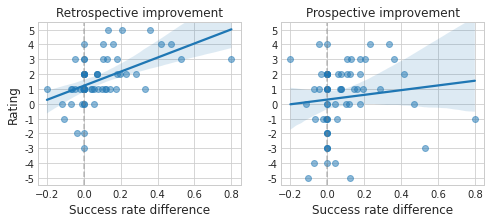

In [181]:
jolds = all_jolds.loc[all_jolds.qid.eq(jold_types['retro']) | all_jolds.qid.eq(jold_types['prosp']), :]
jolds = jolds.reset_index().drop(columns=['inst'])
jolds = jolds.pivot(index=['participant', 'session'], columns='qid', values='value') - 6
jolds = jolds.reset_index()
print('{:.2f} rows are missing jold-8 ratings'.format(jolds.loc[:, jold_types['prosp']].isna().sum()/jolds.shape[0]))

df = trials.merge(jolds, on=['participant', 'session'])
df = df.rename(columns={1: 'jold_R', 8: 'jold_P'})
plot_df = df.loc[~df.loc[:, 'jold_P'].isna(), :]
plot_df = plot_df.assign(
    jold_R = plot_df.jold_R.astype(int),
    jold_P = plot_df.jold_P.astype(int),
    jold_R_jitter = plot_df.jold_R + np.random.uniform(-.1, .1, plot_df.shape[0]),
    jold_P_jitter = plot_df.jold_P + np.random.uniform(-.1, .1, plot_df.shape[0])
)

rc = {'axes.labelsize': 2, 'axes.titleweight': 'bold'}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])

with plt.rc_context(rc):
    for i, judgment in enumerate(['jold_R', 'jold_P']):
        ax[i].axvline(0, color='gray', ls='--', alpha=.5)
        sns.regplot(x='srd', y=judgment, data=plot_df, ax=ax[i], scatter_kws=dict(alpha=.5))
        ax[i].set_ylim(-5.5, 5.5)
        ax[i].set_yticks(np.arange(-5, 6))
        ax[i].set_yticklabels(np.arange(-5, 6).astype(str))

ax[0].set_xlabel('Objective (success rate difference)', fontsize=12)
ax[1].set_xlabel('Objective (success rate difference)', fontsize=12)
ax[0].set_ylabel('Subjective (rating)', fontsize=12)
ax[1].set_ylabel('', fontsize=12)
ax[0].set_title('Retrospective improvement', fontsize=12)
ax[1].set_title('Prospective improvement', fontsize=12)
plt.savefig('../figs/jolds_1_8_and_srd.pdf')

#%%
m1 = smf.ols('jold_R ~ srd', data=df).fit()
m1.summary()
m2 = smf.ols('jold_P ~ srd', data=df).fit()
m2.summary()
m3 = smf.ols('jold_P ~ jold_R + srd', data=df).fit()
display(m2.summary())

n_improvers = len(df.loc[df.sr.eq(0) & df.jold_R.gt(0), 'participant'].unique())
n_total = len(df.participant.unique())
print(f'{n_improvers}/{n_total} = {n_improvers/n_total} reported improvement without an increase in success rate')
# %%

## JOLD 2, 3 and success rate

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  short   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     29.61
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           3.58e-06
Time:                        12:48:13   Log-Likelihood:                -69.703
No. Observations:                  39   AIC:                             143.4
Df Residuals:                      37   BIC:                             146.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5104      0.319      4.739      0.000       0.865       2.156
srd_short      6.2235      1.144      5.442      0.000       3.906       8.541
==============================================================================
Omnibus:                        1.180   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.554   Jarque-Bera (JB):                0.926
Skew:                          -0.040   Prob(JB):                        0.629
Kurtosis:                       2.249   Cond. No.                         4.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/aten/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   long   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     11.18
Date:                Thu, 30 Dec 2021   Prob (F-statistic):            0.00655
Time:                        12:48:13   Log-Likelihood:                -18.392
No. Observations:                  13   AIC:                             40.78
Df Residuals:                      11   BIC:                             41.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8986      0.446      6.504      0.000       1.918       3.880
srd_long       3.0477      0.911      3.344      0.007       1.042       5.054
==============================================================================
Omnibus:                        0.565   Durbin-Watson:                   2.739
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.318
Skew:                          -0.345   Prob(JB):                        0.853
Kurtosis:                       2.669   Cond. No.                         3.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

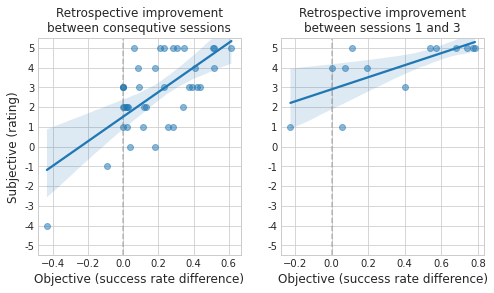

In [182]:
comp_sess_df = trials.filter(items=['participant', 'session', 'sr'])
comp_sess_df['srd_short'] = trials.set_index('participant').groupby('participant').diff(1).loc[:, 'sr'].values
comp_sess_df['srd_long'] = trials.set_index('participant').groupby('participant').diff(2).loc[:, 'sr'].values

jolds = all_jolds.loc[all_jolds.qid.eq(jold_types['short']) | all_jolds.qid.eq(jold_types['long']), :]
jolds = jolds.reset_index().drop(columns=['inst'])
jolds = jolds.pivot(index=['participant', 'session'], columns='qid', values='value') - 6
jolds = jolds.reset_index().sort_values(by=['participant', 'session'])

plot_df = pd.merge(comp_sess_df, jolds, on=['participant', 'session'], how='left')

plot_df = plot_df.rename(columns=jold_types_inv)
# disp(plot_df.head(30))

rc = {'axes.labelsize': 2, 'axes.titleweight': 'bold'}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8, 4], squeeze=True)

with plt.rc_context(rc):
    for i, judgment in enumerate(['short', 'long']):
        ax[i].axvline(0, color='gray', ls='--', alpha=.5)
        sns.regplot(x=f'srd_{judgment}', y=judgment, data=plot_df, ax=ax[i], scatter_kws=dict(alpha=.5))
        ax[i].set_ylim(-5.5, 5.5)
        ax[i].set_yticks(np.arange(-5, 6))
        ax[i].set_yticklabels(np.arange(-5, 6).astype(str))
        ax[i].set_xlabel('Objective (success rate difference)', fontsize=12)

        m = smf.ols(f'{judgment} ~ srd_{judgment}', data=plot_df.dropna(subset=[judgment])).fit()
        disp(m.summary())

ax[0].set_ylabel('Subjective (rating)', fontsize=12)
ax[1].set_ylabel('')
ax[0].set_title('Retrospective improvement\nbetween consequtive sessions', fontsize=12)
ax[1].set_title('Retrospective improvement\nbetween sessions 1 and 3', fontsize=12)

plt.savefig('../figs/jolds_2_3_and_srd_2_3.pdf')

## JOLD and TLX performance item

In [ ]:
def r2z(r):
    '''convert rho to z that is normally distibuted with variance'''
    return 0.5 * np.log((1+r)/(1-r))


def z2r(z):
    return (np.exp(2*z)-1)/(np.exp(2*z)+1)


def r_ci(r, n, alpha=.95):
    z_crits = np.array(norm.interval(alpha, loc=0, scale=1))
    z_r = r2z(r)
    return z2r(z_r + z_crits * np.sqrt( (1+(r**2)/2) / (n-3) ))


def with_zs(df, cols):
    df_ = df.copy()
    for c in cols:
        df_[f'{c}_z'] = zscore(df_.loc[:, c])
    return df_


iv, dv = 'TLX_3_d3', 'JOLD_3'

rc = {'axes.labelsize': 12, 'axes.titleweight': 'bold'}
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[6, 6], squeeze=True)
disp(q_df.columns)
with plt.rc_context(rc):
    keys = [2, 5] 
    for i, judgment in enumerate(['short', 'long']):
        ivs = []
        for j, (iv, dv) in enumerate([(f'srd_{judgment}',  f'JOLD_{keys[i]}'), (f'TLX_3_d{i+2}', f'JOLD_{keys[i]}')]):
            ax[j, i].axvline(0, color='gray', ls='--', alpha=.5)
            ax[j, i].axhline(0, color='gray', ls='--', alpha=.5)
            sns.regplot(x=iv, y=dv, data=q_df, ax=ax[j, i], scatter_kws=dict(alpha=.5))
            ax[j, i].set_ylim(-5.5, 5.5)
            ax[j, i].set_yticks(np.arange(-5, 6))
            ax[j, i].set_yticklabels(np.arange(-5, 6).astype(str))

            ax[j, 0].set_ylabel('Improvement rating', fontsize=12)
            ax[j, 1].set_ylabel('')
            ivs.append(iv)
            m = smf.ols('{0} ~ {1}'.format(dv, f'{iv}_z'), data=with_zs(q_df.dropna(subset=[dv, iv]), [iv])).fit()
            disp(m.summary())

        m = smf.ols('{0} ~ {1}'.format(dv, '+'.join(reversed([f'{iv}_z' for iv in ivs]))), data=with_zs(q_df.dropna(subset=[dv]+ivs), ivs)).fit()
        disp(m.summary())

    ax[0, 0].set_title('Difference between\nconsequtive sessions', fontsize=12)
    ax[0, 1].set_title('Difference between\nsessions 1 and 3', fontsize=12)
    ax[0, 0].set_xlabel('Success rate difference')
    ax[0, 1].set_xlabel('Success rate difference')
    ax[1, 0].set_xlabel('Subjective competence difference')
    ax[1, 1].set_xlabel('Subjective competence difference')
    plt.tight_layout()
# plt.savefig('../figs/jolds_vs_subjective_objective_competence.pdf')

# rho, pval = spearmanr(q_df.loc[:, iv], q_df.loc[:, dv], nan_policy='omit')
# rho_ci = r_ci(rho, n=len(q_df.loc[:, iv]), alpha=.95)
# print('Change in subjective competence between consequtive sessions and JOLD-2:\nSpearmans r = {:.3f}, CI = [{:.3f}, {:.3f}], p = {:.3f}'.format(rho, *rho_ci, pval))

# rho, pval = spearmanr(q_df.srd_short, q_df.JOLD_2, nan_policy='omit')
# rho_ci = r_ci(rho, n=len(q_df.srd_short), alpha=.95)
# print('Change in objective competence between consequtive sessions and JOLD-2:\nSpearmans r = {:.3f}, CI = [{:.3f}, {:.3f}], p = {:.3f}'.format(rho, *rho_ci, pval))

## Prospective JOLD and actual performance-improvement

Spearmans r(23) = 0.293, CI = [-0.124, 0.622], p = 0.155



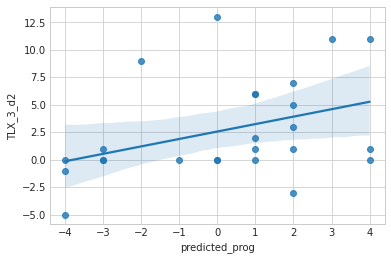

In [267]:
df1 = q_df.loc[:, ['JOLD_1', 'srd', 'srd_short', 'TLX_3_d2']].reset_index()
df2 = df1.copy()
df2['session'] = df1.session + 1
df2 = df2.drop(columns=['srd', 'srd_short', 'TLX_3_d2'])
df2 = df2.rename(columns={'JOLD_1': 'predicted_prog'})

df3 = pd.merge(df1, df2, on=['participant', 'session'], how='left')
df3 = df3.dropna(subset=['predicted_prog']).drop(columns=['JOLD_1'])
del df1, df2

sns.regplot(x='predicted_prog', y='TLX_3_d2', data=df3)

iv, dv = 'predicted_prog', 'srd_short'
rho, pval = spearmanr(df3.loc[:, iv], df3.loc[:, dv], nan_policy='omit')
rho_ci = r_ci(rho, n=len(df3.loc[:, dv]), alpha=.95)
print('Spearmans r({}) = {:.3f}, CI = [{:.3f}, {:.3f}], p = {:.3f}'.format(len(df3.loc[:, dv]) - 2, rho, *rho_ci, pval))
print()

# JOLDs and motivation

,SIMS_1,SIMS_2,SIMS_3,SIMS_4,MSLQ_3,MSLQ_5,MSLQ_6
srd,-0.049,-0.017,0.205,0.213,0.300,0.135,0.196
srd_short,-0.099,0.175,-0.078,0.181,0.524,0.454,0.604
srd_long,-0.277,0.262,-0.149,0.217,0.481,0.452,0.625
TLX_3_d2,-0.118,-0.035,0.073,0.165,0.412,0.305,0.467
JOLD_3,0.128,0.024,0.092,0.166,0.317,0.263,0.251
JOLD_2,-0.105,0.086,0.169,0.268,0.270,0.272,0.264
JOLD_5,-0.153,0.091,-0.003,0.353,0.227,0.399,0.652
JOLD_1,0.138,-0.044,0.155,0.202,0.324,0.198,0.250


/tmp/ipykernel_197/2991597074.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


IV: srd
------------------------------
Amotivation, r(83) = -0.049, p = 0.6580
External regulation, r(83) = -0.017, p = 0.8807
Identified regulation, r(83) = 0.205, p = 0.0596
	**Intrinsic motivation, r(83) = 0.213, CI = [-0.002097, 0.410066]
	**Extrinsic Goal Orientation, r(83) = 0.300, CI = [0.088089, 0.486021]
Control of Learning Beliefs, r(83) = 0.135, p = 0.2191
Self-Efficacy for Learning and Performance, r(83) = 0.196, p = 0.0716
IV: srd_short
------------------------------
Amotivation, r(37) = -0.099, p = 0.5504
External regulation, r(37) = 0.175, p = 0.2862
Identified regulation, r(37) = -0.078, p = 0.6350
Intrinsic motivation, r(37) = 0.181, p = 0.2705
	**Extrinsic Goal Orientation, r(37) = 0.524, CI = [0.229366, 0.730711]
	**Control of Learning Beliefs, r(37) = 0.454, CI = [0.145601, 0.681978]
	**Self-Efficacy for Learning and Performance, r(37) = 0.604, CI = [0.331085, 0.783526]
IV: srd_long
------------------------------
Amotivation, r(11) = -0.277, p = 0.3596
External regu

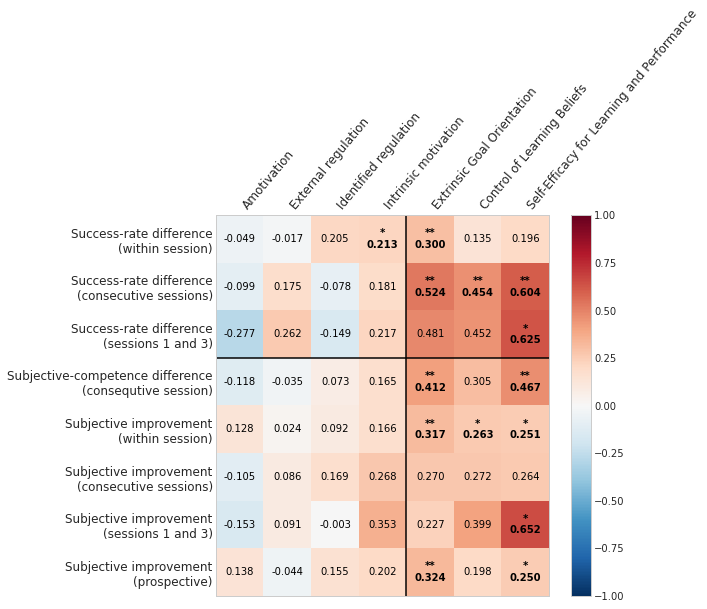

In [392]:
ivs = ['srd', 'srd_short', 'srd_long', 'TLX_3_d2', 'JOLD_3', 'JOLD_2', 'JOLD_5', 'JOLD_1']
dvs = ['SIMS_1', 'SIMS_2', 'SIMS_3', 'SIMS_4', 'MSLQ_3', 'MSLQ_5', 'MSLQ_6']
covs = ['MSLQ_1']
choose = ivs + dvs + covs
subdf = q_df.loc[:, choose]

for cov in covs:
    to_merge = subdf.groupby('participant').fillna(method='bfill')[[cov]].groupby('participant').fillna(method='ffill')
    to_merge.columns = ['c'+cov]
    subdf = pd.merge(subdf, to_merge, on=['participant', 'session'])

ld = dict(zip(ccodes.ccode, ccodes.component))
ld['srd'] = 'Success-rate difference\n(within session)'
ld['srd_short'] = 'Success-rate difference\n(consecutive sessions)'
ld['srd_long'] = 'Success-rate difference\n(sessions 1 and 3)'
ld['TLX_3_d2'] = 'Subjective-competence difference\n(consequtive session)'
ld['JOLD_3'] = 'Subjective improvement\n(within session)'
ld['JOLD_2'] = 'Subjective improvement\n(consecutive sessions)'
ld['JOLD_5'] = 'Subjective improvement\n(sessions 1 and 3)'
ld['JOLD_1'] = 'Subjective improvement\n(prospective)'

# # Pandas correlation matrix
rs = np.random.RandomState(0)
corr = subdf.corr(method='spearman').loc[ivs, dvs]
disp(corr.style.background_gradient(cmap='RdBu_r', axis=1).format(precision=3))
# disp(subdf.head(50))

# Matplotlib plot
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=[8, 7])
cax = ax.matshow(corr.values, vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(cax)
ax.axvline(3.5, color='k')
ax.axhline(2.5, color='k')
ax.set_xticks(np.arange(len(dvs)))
ax.set_yticks(list(range(len(ivs))))
ax.set_xticklabels([ld[k] for k in dvs], ha='left', fontsize=12)
ax.set_yticklabels([ld[k] for k in ivs], fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=50)
plt.grid(False)

for i, iv in enumerate(ivs):
    print('==='*10)
    print(f'IV: {iv}')
    print('---'*10)
    for j, dv in enumerate(dvs):
        x, y = subdf.loc[:, iv], subdf.loc[:, dv]
        n = min((x.dropna().shape[0], y.dropna().shape[0]))
        r, p = spearmanr(x, y, nan_policy='omit')
        ci = r_ci(r, n, .95)
        dv_long = ccodes.loc[ccodes.ccode.eq(dv), 'component'].values.squeeze()
        t, sg = f'{r:.3f}', ''
        pcorr = pg.partial_corr(data=subdf, x=iv, y=dv, method='spearman', covar=['c'+c for c in covs])#.loc[ivs, dvs]
        pr, pp = pcorr.values.squeeze()[[1, 3]]
        # print(pcorr)
        if p < .05:
            fw = 'bold'
            sg += '*\n'
            if p < .01:
                sg = '**\n'
            print(f'\t**{dv_long}, r({n-2}) = {r:.3f}, CI = [{ci[0]:3f}, {ci[1]:3f}]')#, p = {p:.4f}** | partial r = {pr:.3f}, p = {pp:.3f}')
        else:
            print(f'{dv_long}, r({n-2}) = {r:.3f}, p = {p:.4f}')#, partial r = {pr:.3f}, p = {pp:.3f}')
            fw = 'normal'
        ax.text(j, i, sg+t, ha='center', va='center', color='k', fontweight=fw)
    print('==='*10)

    plt.savefig('../data_visualization/motivation_corrs.pdf')


# Spare cells

In [389]:
def print_component_questions(component, df):
    print(component)
    for i, prompt in enumerate(df.loc[df.component==component, 'prompt'].unique()):
        print(f'\t{i+1}) {prompt}')

for dv in dvs:
    print_component_questions(ld[dv], qs)

Amotivation
	1) I do this activity but I am not sure if it is worth my time
	2) I don’t know; I don’t see what this game brings me
	3) There may be good reasons for practicing this game, but personally I don’t see any
	4) I keep practicing, but I am not sure I should continue
External regulation
	1) Because I feel that I have to do it
	2) Because I am supposed to do it
	3) Because I don’t have any choice
	4) Because it is something that I have to do
Identified regulation
	1) Because I believe that this game is important for me
	2) It is for my own good
	3) Because I think that this activity is good for me
	4) Because I feel like playing this game
Intrinsic motivation
	1) Because I feel good when playing this game
	2) Because this game is fun
	3) Because I think that this activity is pleasant
	4) Because I think that this game is interesting
Extrinsic Goal Orientation
	1) I want to do well in this game because it is important to show my ability to others
	2) If I can, I want to get bett